In [43]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt

cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv("sentiment140_utf8.csv",
                names=cols,
                 encoding='latin-1')

df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [44]:
df.drop(['id','date','query_string','user'],axis=1,inplace=True)
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})


In [45]:
df['pre_clean_len'] = [len(t) for t in df.text]

In [46]:
from bs4 import BeautifulSoup
example1 = BeautifulSoup(df.text[279], 'lxml')
print(example1.get_text())

Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. 


In [47]:
import re
re.sub(r'@[A-Za-z0-9]+','',df.text[343])

' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [48]:
re.sub('https?://[A-Za-z0-9./]+','',df.text[0])

"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [49]:
df.text[226]

re.sub(r'[^\x00-\x7F]+', ' ', df.text[226])

'Tuesday ll start with reflection  n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [50]:
re.sub("[^a-zA-Z]", " ", df.text[175])

' machineplay I m so sorry you re having to go through this  Again    therapyfail'

Here we need to define the data cleaning tasks.

Above we have tried to fix the following:
1. HTML decoding - removing stuff like &amp etc.
2. @ mentions - removing just the @s, keeping the usernames.
3. URL links - anything with http should be removed
4. Unicode replacement characters - we replace them with spaces for the time being.
5. Hashtags and numbers - here we try to replace them with spaces, keeping the original function intact.

In [51]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    
    # Handle Unicode replacement characters
    lower_case = re.sub(r'[^\x00-\x7F]+', ' ', lower_case)
    
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessary white spaces,
    # I will tokenize and join together to remove unnecessary white spaces
    words = [x for x in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [52]:
%%time
print("Cleaning the tweets...\n")

clean_tweet_texts = []
for i in range(0, len(df)):
    if (i+1) % 100000 == 0:
        print("Tweets %d of %d has been processed" % (i+1, len(df)))
    clean_tweet_texts.append(tweet_cleaner_updated(df['text'][i]))

Cleaning the tweets...


C:\Users\calyc\AppData\Local\Temp\ipykernel_24340\1525096433.py:26: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'lxml')


Tweets 100000 of 1600000 has been processed
Tweets 200000 of 1600000 has been processed
Tweets 300000 of 1600000 has been processed
Tweets 400000 of 1600000 has been processed
Tweets 500000 of 1600000 has been processed
Tweets 600000 of 1600000 has been processed
Tweets 700000 of 1600000 has been processed
Tweets 800000 of 1600000 has been processed
Tweets 900000 of 1600000 has been processed
Tweets 1000000 of 1600000 has been processed
Tweets 1100000 of 1600000 has been processed
Tweets 1200000 of 1600000 has been processed
Tweets 1300000 of 1600000 has been processed
Tweets 1400000 of 1600000 has been processed
Tweets 1500000 of 1600000 has been processed
Tweets 1600000 of 1600000 has been processed
CPU times: total: 1min 33s
Wall time: 2min 8s


In [53]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment
clean_df.to_csv('clean_tweet.csv',encoding='utf-8')

In [54]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [60]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596041 non-null  object
 1   target  1596041 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


Now that data cleaning has been completed, let's first do some basic visualisation tasks. We can proceed by first trying out the controversial WordCloud.

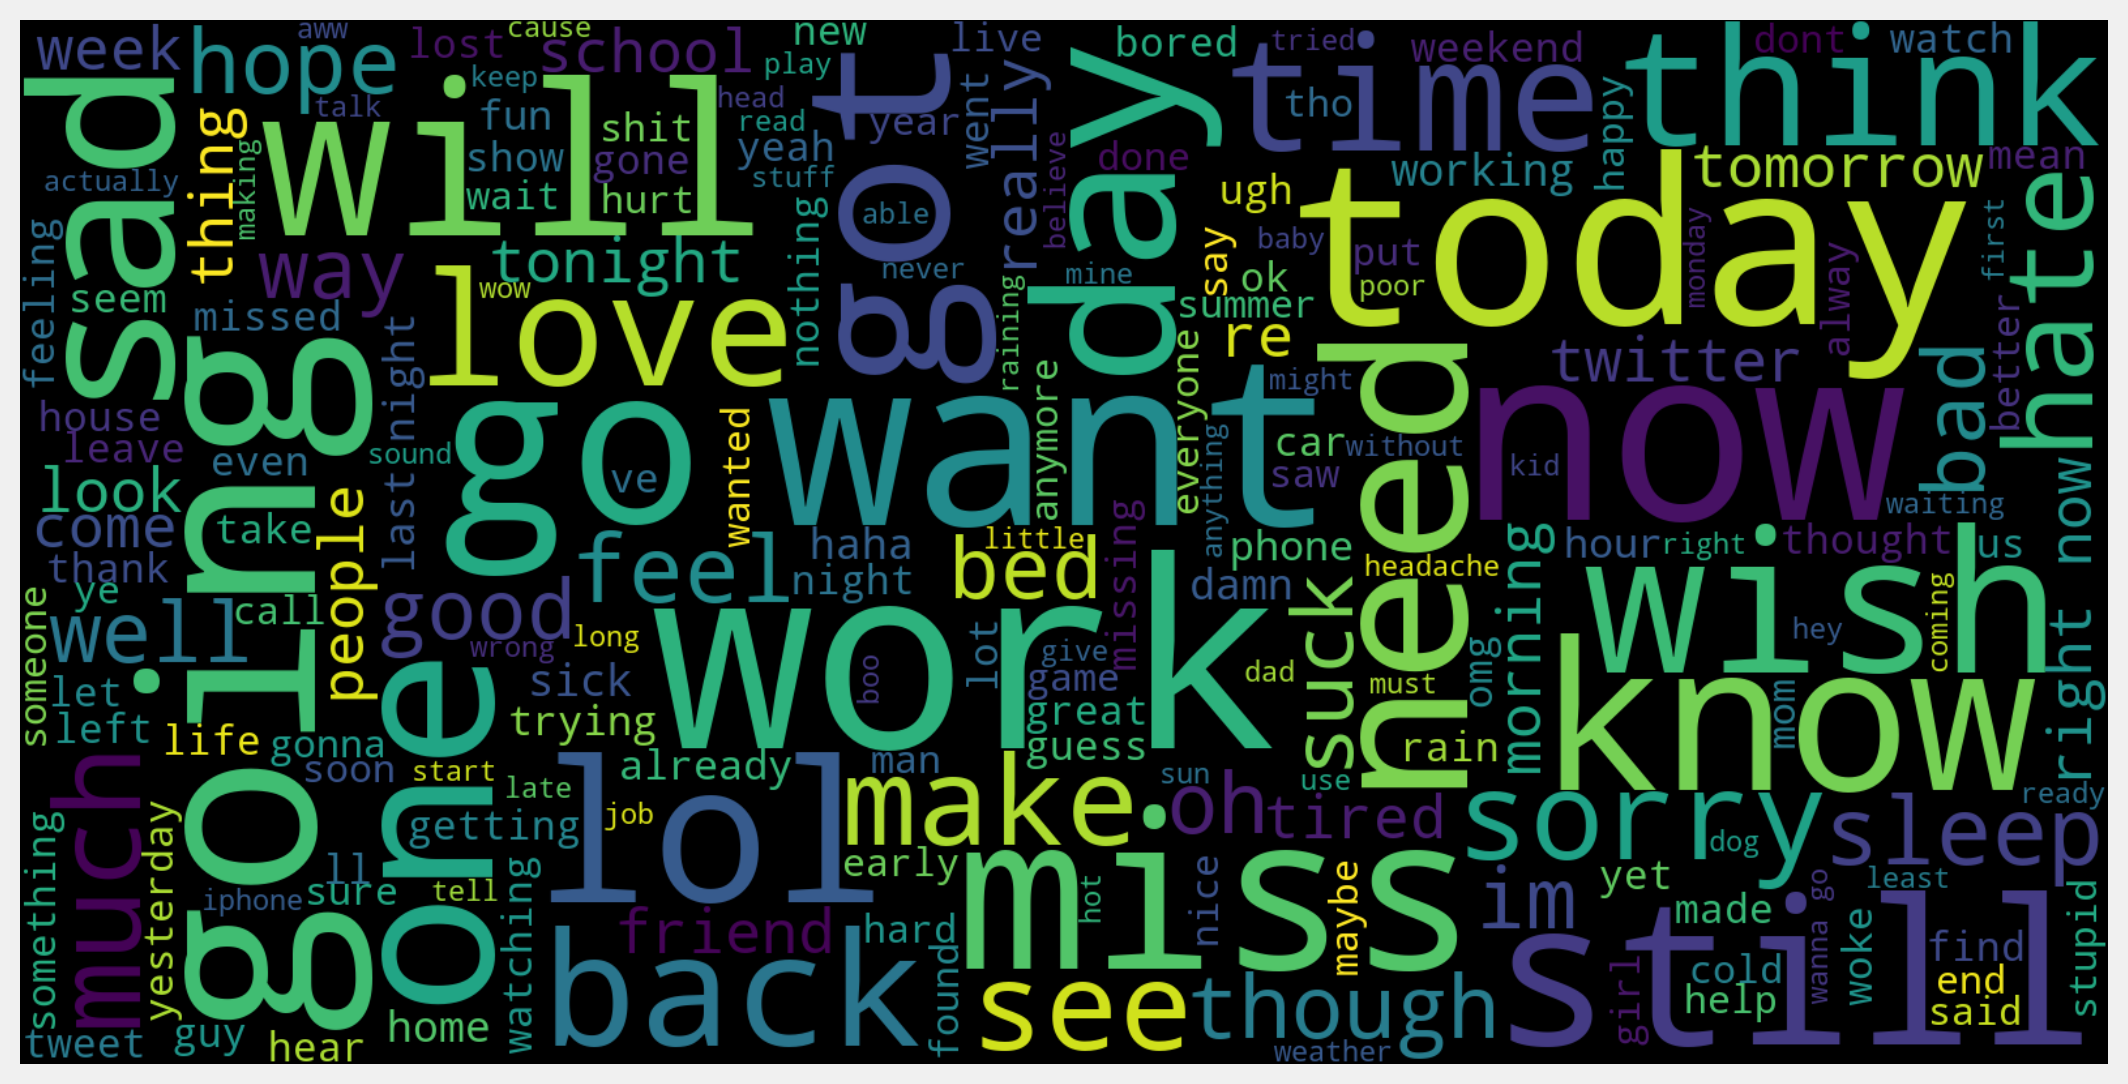

In [39]:
neg_tweets = my_df[my_df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



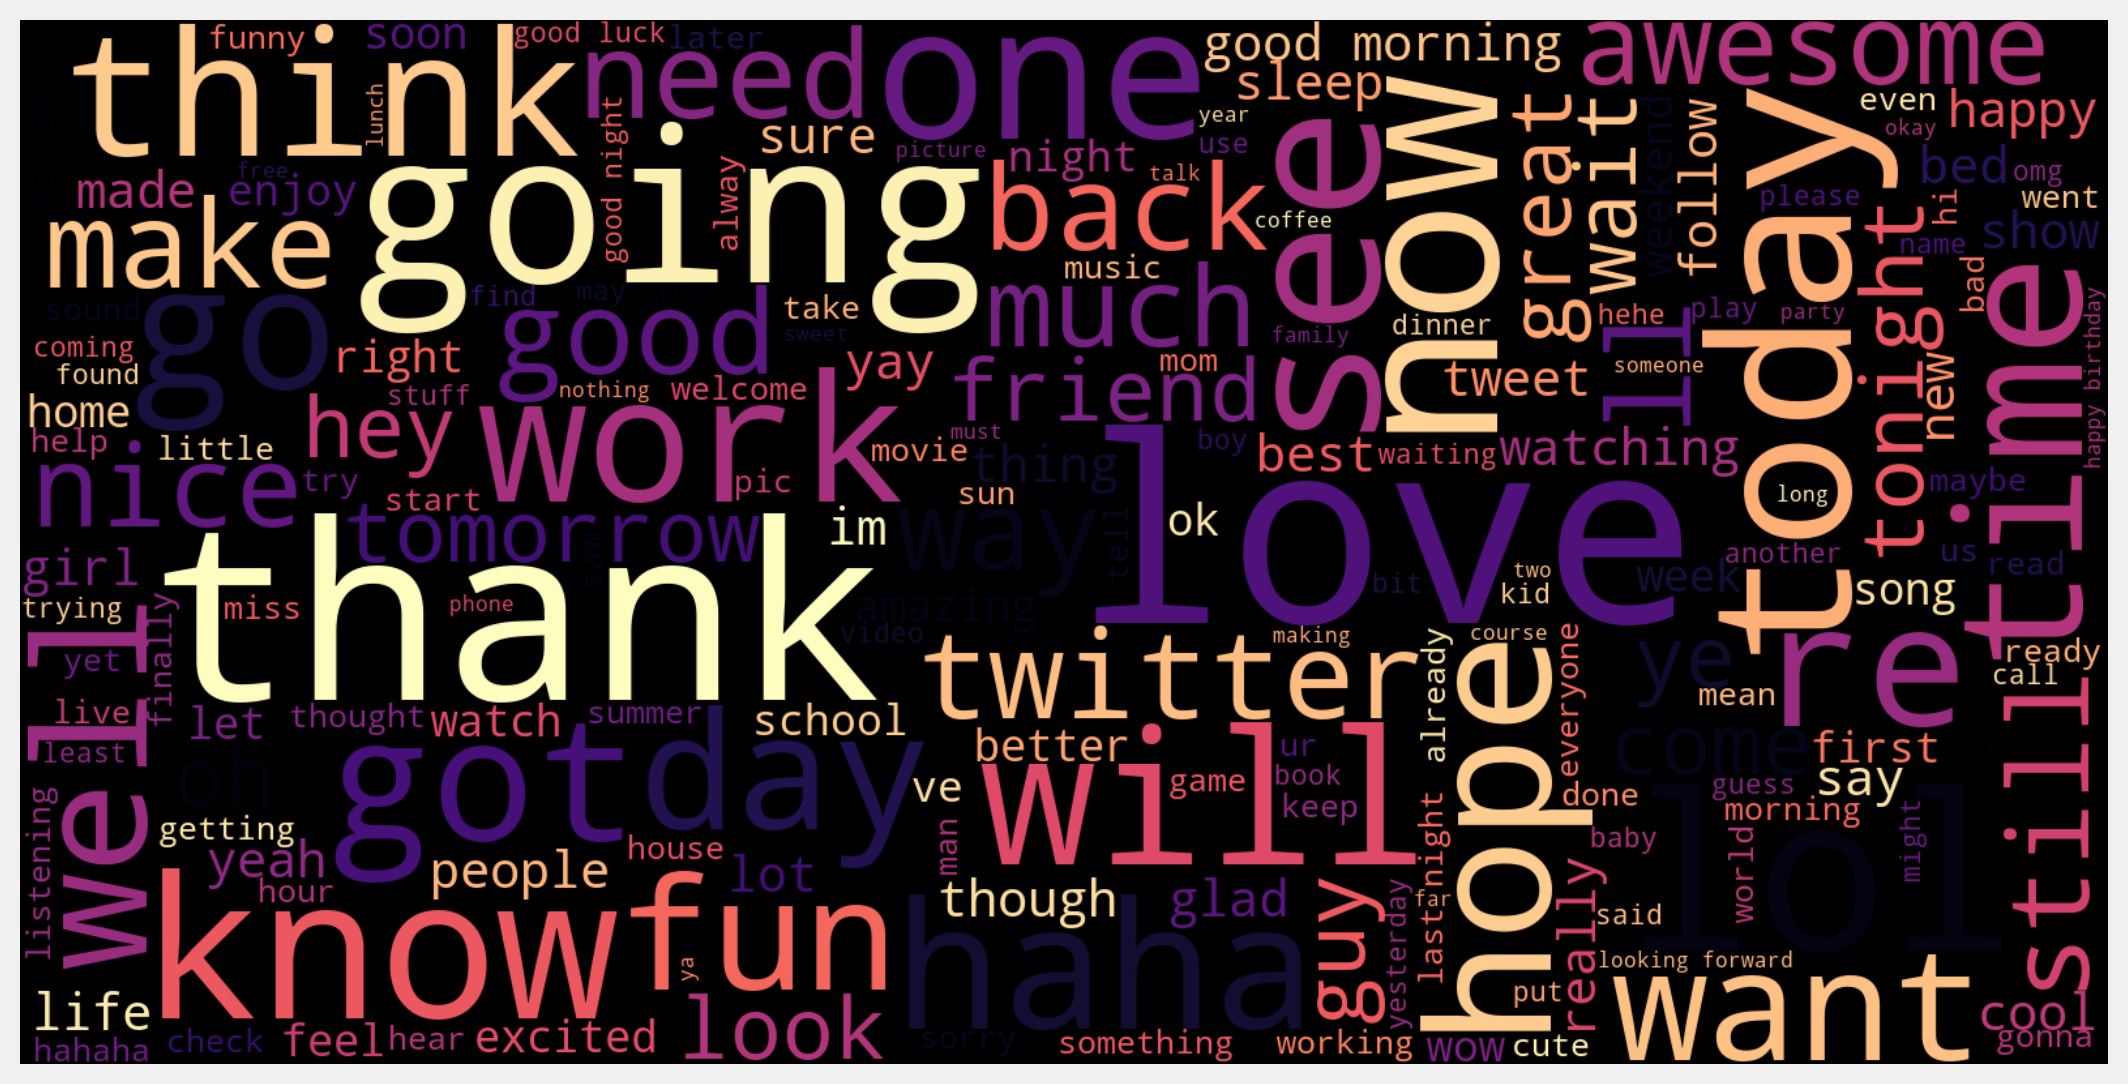

In [40]:
pos_tweets = my_df[my_df.target == 1]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



Now we need some term frequency data to work with. We can try using a count vectorizer to calculate term frequencies.

In [69]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = cvec = CountVectorizer(stop_words='english',max_features=10000)
cvec.fit(my_df.text)

CountVectorizer(max_features=10000, stop_words='english')

In [70]:
len(cvec.get_feature_names_out())

10000

We can directly obtain the term frequencies as below:

In [71]:
neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text)
pos_doc_matrix = cvec.transform(my_df[my_df.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names_out()).transpose()

In [72]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

term_freq_df

,negative,positive,total
aa,160,92,252
aaa,93,54,147
aaaa,45,29,74
aaaah,76,61,137
aaaand,33,37,70
...,...,...,...
zune,87,57,144
zzz,88,96,184
zzzz,53,65,118
zzzzz,44,47,91


With this frequency table, we can then try to see how the words follow Zipf's Law.

C:\Users\calyc\AppData\Local\Temp\ipykernel_10756\3851007787.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frequencies = counts[indices]
C:\Users\calyc\AppData\Local\Temp\ipykernel_10756\3851007787.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
C:\Users\calyc\AppData\Local\Temp\ipykernel_10756\3851007787.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dummy =

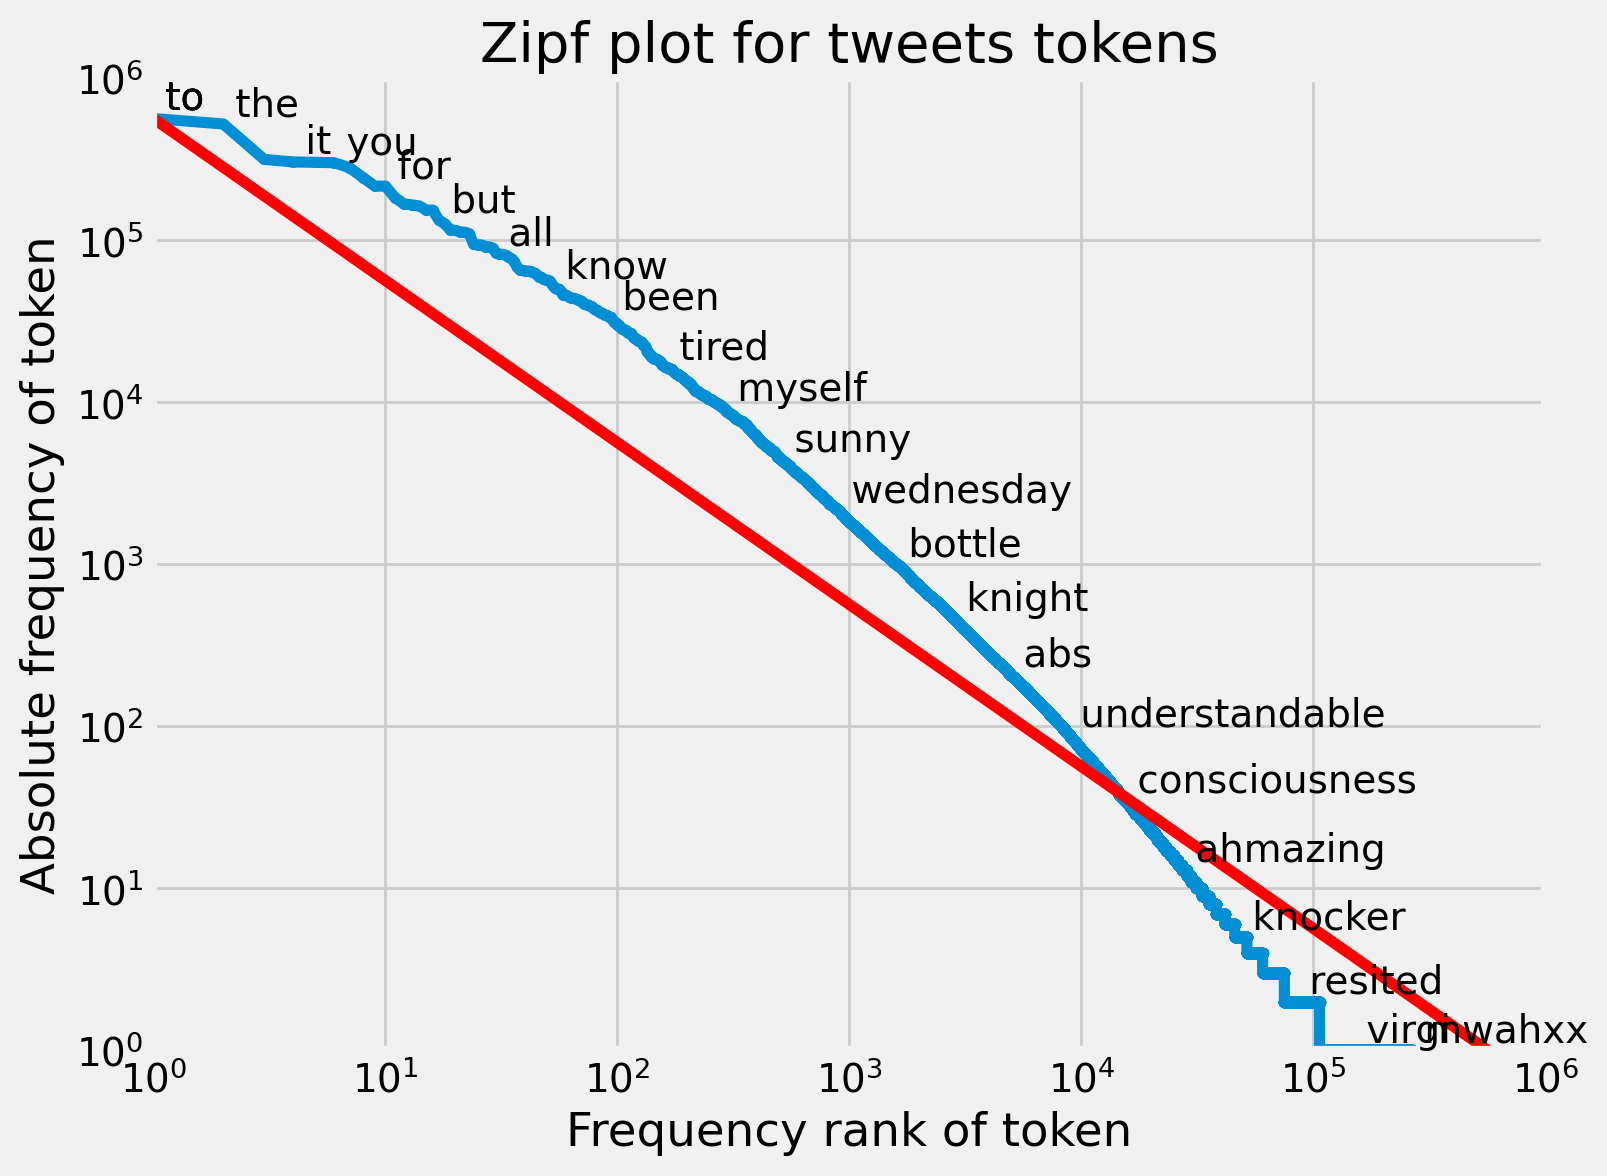

In [51]:


from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

The most frequent words that appear are "stop words", such as "to", "the" etc which do not convey meaningful information about sentimentality of the tweet. What we can do is to check the frequency of which a word appears more often in one class or another (e.g. rate). A second alternative might be to create a "neutral" class, but we can do that in a later exercise.

In [73]:
term_freq_df2 = term_freq_df

In [74]:
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate
emailunlimited,0,100,100,1.000000
dividends,0,83,83,1.000000
mileymonday,0,161,161,1.000000
shareholder,1,80,81,0.987654
fuzzball,2,99,101,0.980198
recommends,3,109,112,0.973214
delongeday,6,162,168,0.964286
atcha,3,80,83,0.963855
timestamp,3,68,71,0.957746
shaundiviney,4,89,93,0.956989


In [75]:
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct
just,64004,62944,126948,0.495825,0.014396
good,29209,62118,91327,0.680171,0.014207
day,41374,48186,89560,0.538030,0.011021
love,16990,47694,64684,0.737338,0.010908
like,41050,37520,78570,0.477536,0.008581
lol,23123,36118,59241,0.609679,0.008261
thanks,5768,34375,40143,0.856314,0.007862
going,33689,30939,64628,0.478724,0.007076
time,27526,30432,57958,0.525070,0.006960
today,38116,30100,68216,0.441245,0.006884


In [76]:
from scipy.stats import hmean

term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])
                                                                   if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean
just,64004,62944,126948,0.495825,0.014396,0.027980
good,29209,62118,91327,0.680171,0.014207,0.027833
day,41374,48186,89560,0.538030,0.011021,0.021599
love,16990,47694,64684,0.737338,0.010908,0.021498
like,41050,37520,78570,0.477536,0.008581,0.016860
lol,23123,36118,59241,0.609679,0.008261,0.016300
thanks,5768,34375,40143,0.856314,0.007862,0.015581
going,33689,30939,64628,0.478724,0.007076,0.013946
time,27526,30432,57958,0.525070,0.006960,0.013738
today,38116,30100,68216,0.441245,0.006884,0.013557


In [77]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
term_freq_df2.sort_values(by='pos_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean
welcome,620,6702,7322,0.915324,0.001533,0.003061,0.995623,0.999369,0.997493
thank,2282,15736,18018,0.873349,0.003599,0.007168,0.990791,1.000000,0.995374
thanks,5768,34375,40143,0.856314,0.007862,0.015581,0.987770,1.000000,0.993847
awesome,3821,14469,18290,0.791088,0.003309,0.006591,0.967038,1.000000,0.983243
glad,2273,8255,10528,0.784100,0.001888,0.003767,0.963666,0.999971,0.981483
follow,2552,9154,11706,0.781992,0.002094,0.004176,0.962596,0.999996,0.980940
enjoy,1642,5876,7518,0.781591,0.001344,0.002683,0.962389,0.997441,0.979602
sweet,1610,5646,7256,0.778115,0.001291,0.002578,0.960559,0.996331,0.978118
yay,3165,10501,13666,0.768403,0.002402,0.004788,0.955061,1.000000,0.977014
hello,1122,4524,5646,0.801275,0.001035,0.002067,0.971487,0.982293,0.976860


Text(0.5, 1.0, 'neg_hmean vs pos_hmean')

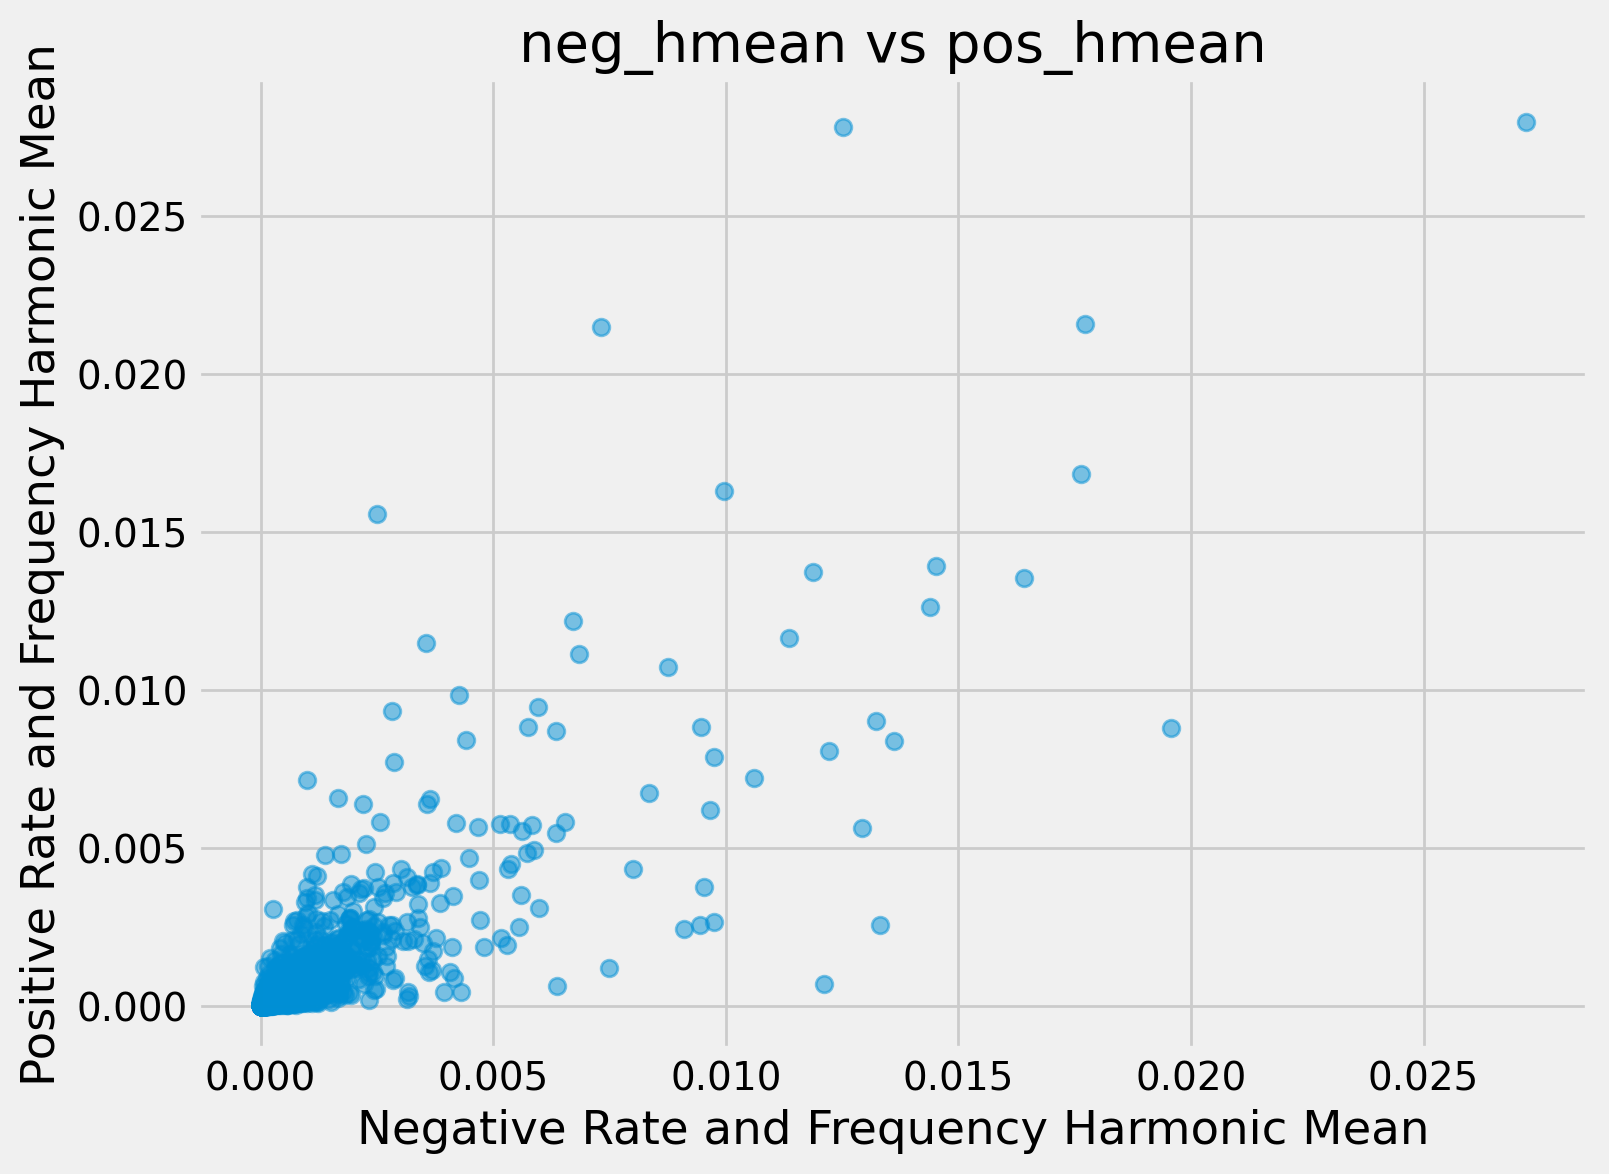

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']
term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()
term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])
                                                                   if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])
term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])
term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])
term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Now, we can proceed to training the model. We first get a couple of baselines, which are the Zero rule and TextBlob.

In [4]:
x = my_df.text
y = my_df.target

from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 1564120 entries with 50.02% negative, 49.98% positive
Validation set has total 15960 entries with 49.45% negative, 50.55% positive
Test set has total 15961 entries with 49.68% negative, 50.32% positive


In [84]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [85]:
%%time
tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 1 for n in tbresult]

CPU times: total: 453 ms
Wall time: 1.18 s


In [87]:
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1, 0]))

confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive', 'predicted_negative'])
print("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred) * 100))
print("-" * 80)
print("Confusion Matrix\n")
print(confusion)
print("-" * 80)
print("Classification Report\n")
print(classification_report(y_validation, tbpred))

Accuracy Score: 61.84%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                7282                 785
negative                5306                2587
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

           0       0.77      0.33      0.46      7893
           1       0.58      0.90      0.71      8067

    accuracy                           0.62     15960
   macro avg       0.67      0.62      0.58     15960
weighted avg       0.67      0.62      0.58     15960


To use text in ML, we can use a bag-of-words approach. Given the large amount of vocabulary, we may first need to try a couple of different approaches before we know what the optimal number of features are.

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [91]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test) * 1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test) * 1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test) * 1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy * 100))
    print("accuracy score: {0:.2f}%".format(accuracy * 100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy - null_accuracy) * 100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy - accuracy) * 100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-" * 80)
    return accuracy, train_test_time

In [92]:
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy, tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n, nfeature_accuracy, tt_time))
    return result

In [95]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test) * 1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test) * 1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test) * 1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0, 1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                             columns=['predicted_negative', 'predicted_positive'])
    print("null accuracy: {0:.2f}%".format(null_accuracy * 100))
    print("accuracy score: {0:.2f}%".format(accuracy * 100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy - null_accuracy) * 100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy - accuracy) * 100))
    print("-" * 80)
    print("Confusion Matrix\n")
    print(confusion)
    print("-" * 80)
    print("Classification Report\n")
    print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

In [96]:
%%time
ug_cvec = CountVectorizer(max_features=80000)
ug_pipeline = Pipeline([
        ('vectorizer', ug_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(ug_pipeline, x_train, y_train, x_validation, y_validation)

null accuracy: 50.55%
accuracy score: 79.87%
model is 29.32% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6081                1812
positive                1401                6666
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.81      0.77      0.79      7893
    positive       0.79      0.83      0.81      8067

    accuracy                           0.80     15960
   macro avg       0.80      0.80      0.80     15960
weighted avg       0.80      0.80      0.80     15960

CPU times: total: 9.38 s
Wall time: 17.6 s


C:\Users\calyc\PycharmProjects\sentiment_analysis\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [97]:
%%time
tg_cvec = CountVectorizer(max_features=80000,ngram_range=(1, 3))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(tg_pipeline, x_train, y_train, x_validation, y_validation)

C:\Users\calyc\PycharmProjects\sentiment_analysis\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 82.28%
model is 31.74% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6312                1581
positive                1247                6820
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.84      0.80      0.82      7893
    positive       0.81      0.85      0.83      8067

    accuracy                           0.82     15960
   macro avg       0.82      0.82      0.82     15960
weighted avg       0.82      0.82      0.82     15960

CPU times: total: 49.8 s
Wall time: 1min 2s


In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

In [ ]:
%%time
print ("RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

Next, let's experiment with using PyTorch.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader


In [5]:
# Convert text column to string type

csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv, index_col=0)
my_df.head()
my_df.dropna(inplace=True)
my_df.reset_index(drop=True, inplace=True)
my_df.info()

x = my_df.text
y = my_df.target

from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

# Create train, validation, and test datasets
train_data = list(zip(x_train, y_train))
valid_data = list(zip(x_validation, y_validation))
test_data = list(zip(x_test, y_test))

print("Number of samples in my_df:", len(my_df))  
print("Length of train_data:", len(train_data))
print("Length of valid_data:", len(valid_data))
print("Length of test_data:", len(test_data))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596041 non-null  object
 1   target  1596041 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB
Number of samples in my_df: 1596041
Length of train_data: 1564120
Length of valid_data: 15960
Length of test_data: 15961


In [6]:
my_df

,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0
...,...,...
1596036,just woke up having no school is the best feel...,1
1596037,thewdb com very cool to hear old walt interviews,1
1596038,are you ready for your mojo makeover ask me fo...,1
1596039,happy th birthday to my boo of alll time tupac...,1


In [7]:
# Define the tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

# Create vocabulary
def yield_tokens(data_iter):
    for text, _ in data_iter:  # Unpack the tuple
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Create data iterators
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
def collate_batch(batch):
    label_list, text_list = [], []
    for (_text, _label) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(vocab(tokenizer(_text)), dtype=torch.int64)
        text_list.append(processed_text)

    label_list = torch.tensor(label_list, dtype=torch.float32) 
    text_list = torch.nn.utils.rnn.pad_sequence(text_list, batch_first=True)
    return label_list.to(device), text_list.to(device)

In [19]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_data, batch_size=64, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False, collate_fn=collate_batch)

print("Dataloaders created!")   # Check if this message prints
print(len(train_dataloader), len(valid_dataloader), len(test_dataloader)) # Check dataset lengths


Dataloaders created!
24440 250 250


In [20]:
# Define the model
class RNNBinaryClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)  

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        hidden = hidden[-1]
        out = self.fc(hidden)
        out = torch.sigmoid(out)
        return out[:, 1]

# Instantiate the model
input_dim = len(vocab)
embedding_dim = 100
hidden_dim = 256
output_dim = 2  
num_layers = 2  # Example; adjust as needed  

model = RNNBinaryClassifier(input_dim, embedding_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [21]:
from tqdm import tqdm

# Train the model
epochs = 5
for epoch in range(epochs):
    train_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
    for batch in progress_bar:
        labels, texts = batch
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        progress_bar.set_postfix({"Training Loss": float(train_loss / (progress_bar.n + 1))})

Epoch 5/5: 100%|██████████| 24440/24440 [05:46<00:00, 70.51batch/s, Training Loss=0.275]


In [23]:
torch.save(model, "sentiment140.pt")


In [26]:
# Evaluate on the validation set
model.eval()
with torch.no_grad():
    valid_preds = []
    for labels, texts in valid_dataloader:
        predictions = model(texts).squeeze()
        valid_preds.append(predictions.cpu().numpy())

valid_preds = np.concatenate(valid_preds)

In [33]:
# Get the text, true labels from the validation set
valid_texts = [text for text, _ in valid_data]
valid_labels = [label for _, label in valid_data]

# Create a DataFrame with predicted probabilities, true labels, and original texts
valid_results = pd.DataFrame({
    'text': valid_texts,
    'pred_prob': valid_preds,
    'true_label': valid_labels
})

valid_results

,text,pred_prob,true_label
0,it was my last resort,0.425868,0
1,drinking champagne while finish up work on my ...,0.979392,1
2,the weather is good here too and am off to wor...,0.406454,0
3,he the saddest native ui element ever,0.009800,0
4,you lucky sausage you,0.530007,1
...,...,...,...
15955,hallo ihr alle broadcasting live at,0.947932,1
15956,shy has been sick arnica today and made his fe...,0.004437,0
15957,can start on monday very reasonable rates did ...,0.314354,1
15958,why the fuck is following me,0.031287,0


In [34]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Assuming you have the predicted probabilities and true labels in the 'valid_results' DataFrame
valid_results['pred_label'] = (valid_results['pred_prob'] > 0.5).astype(int)

# Compute evaluation metrics
accuracy = accuracy_score(valid_results['true_label'], valid_results['pred_label'])
f1 = f1_score(valid_results['true_label'], valid_results['pred_label'])
precision = precision_score(valid_results['true_label'], valid_results['pred_label'])
recall = recall_score(valid_results['true_label'], valid_results['pred_label'])

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1-Score: {f1:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")

Validation Accuracy: 0.8297
Validation F1-Score: 0.8296
Validation Precision: 0.8393
Validation Recall: 0.8201


These results look pretty good! Now, let's play around with our model, and see if we can get it to predict the sentiment of some new text that we have.

In [41]:
import torch

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained model on the desired device
sentiment140 = torch.load('sentiment140.pt', map_location=device)
sentiment140.eval()  # Set the model to evaluation mode

# Define the tokenizer and vocabulary
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Move the vocabulary to the device
vocab = vocab.to(device)

# Function to preprocess and tokenize text
def preprocess_text(text):
    tokenized_text = torch.tensor(vocab(tokenizer(text)), dtype=torch.int64, device=device)
    padded_text = torch.nn.utils.rnn.pad_sequence([tokenized_text], batch_first=True, padding_value=vocab["<unk>"])
    return padded_text

# Function to predict sentiment
def predict_sentiment(text):
    preprocessed_text = preprocess_text(text)
    with torch.no_grad():
        prediction = sentiment140(preprocessed_text).squeeze()
        sentiment_prob = prediction.item()
    return sentiment_prob


Sentiment probability (positive): 0.9888
Predicted sentiment: Positive


In [54]:
# Function to print the sentiment prediction
def print_sentiment_prediction(input_text):
    sentiment_prob = predict_sentiment(input_text)
    print(f"Input text: {input_text}")
    print(f"Sentiment probability (positive): {sentiment_prob:.4f}")
    if sentiment_prob > 0.66:
        print("Predicted sentiment: Positive")
    elif sentiment_prob < 0.33:
        print("Predicted sentiment: Negative")
    else:
        print("Predicted sentiment: Neutral")
    print()

In [43]:
print_sentiment_prediction("This movie was amazing! I loved every second of it.")

Input text: This movie was amazing! I loved every second of it.
Sentiment probability (positive): 0.9888
Predicted sentiment: Positive


In [44]:
print_sentiment_prediction("I had a terrible experience with this product. It was a waste of money.")

Input text: I had a terrible experience with this product. It was a waste of money.
Sentiment probability (positive): 0.0163
Predicted sentiment: Negative


In [1]:
print_sentiment_prediction("hahaha")

NameError: name 'print_sentiment_prediction' is not defined